# PROJECT OVERVIEW

Introduction:

Tons of people move to NYC everyday - and with a city so diverse with a lot of different neighborhoods and different standards of living, people tend to try out as much as they can while living in the city. The changes of one's environment is as fast paced as the city itself. You can go from having 8 roommates in a 5 bedroom apartment, get tired of them and move to a studio, meet a partner and then move to a 1 bedroom or get a new remote job that made you move to a 2 bedroom for a home office all within a short amount of time. This also applies to anyone out of the city planning to save money to finally chase their dreams in NYC while properly budgeting. So this project aims to help you plan your NYC life, which finding an apartment within your budget and preffered neighborhood is such an important factor.

Data:

- The data used for this project will be the median asking price rental data extracted from the Streeteasy Data Dashboard for Studios, One Bedrooms and Three Bedrooms +

- This data contains median asking price that dates back to 2015 up to May of 2020
    
- The frequency of the data will be monthly

## Importing Packages & Loading the Data

In [122]:
#importing packages

import pandas as pd
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.model_selection import TimeSeriesSplit

from fbprophet import Prophet

import folium

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#!pip install fbprophet

In [3]:
#read in all datasets

#median rent asking price for studio, 1br and 3br+
rent_studio = pd.read_csv('csvs/medianAskingRent_Studio.csv')
rent_1br = pd.read_csv('csvs/medianAskingRent_OneBd.csv')
rent_3br_plus = pd.read_csv('csvs/medianAskingRent_ThreePlusBd.csv')

#inventory for studio, 1br and 3br+
inv_studio = pd.read_csv('csvs/rentalInventory_Studio.csv')
inv_1br = pd.read_csv('csvs/rentalInventory_OneBd.csv')
inv_3br_plus = pd.read_csv('csvs/rentalInventory_ThreePlusBd.csv')

In [7]:
#We'll be using rent data from 2015 to May 2020

#rent_studio.head(3)

In [5]:
#transpose dataset, rename columns, change index to datetime object

#studio
studio_df = rent_studio.T
studio_df.columns = rent_studio.iloc[:,0]
studio_df.drop(['areaName','Borough','areaType'], axis=0, inplace=True)
studio_df.index = pd.to_datetime(studio_df.index)

#1br
onebr_df = rent_1br.T
onebr_df.columns = rent_1br.iloc[:,0]
onebr_df.drop(['areaName','Borough','areaType'], axis=0, inplace=True)
onebr_df.index = pd.to_datetime(onebr_df.index)

#3br+
threebr_df = rent_3br_plus.T
threebr_df.columns = rent_3br_plus.iloc[:,0]
threebr_df.drop(['areaName','Borough','areaType'], axis=0, inplace=True)
threebr_df.index = pd.to_datetime(threebr_df.index)

Neighborhoods:

- Astoria
- Greenpoint
- Woodside

In [6]:
#filter dataframes | we only want 2015-2020 rental data of the three neighborhoods mentioned above

agw_studios = studio_df.iloc[60:][['Astoria', 'Greenpoint', 'Sunnyside']]
agw_1br = onebr_df.iloc[60:][['Astoria', 'Greenpoint', 'Sunnyside']]
agw_3br = threebr_df.iloc[60:][['Astoria', 'Greenpoint', 'Sunnyside']]

## Astoria 

In [137]:
#map of Astoria using folium and its longtitude and latitude

astoria_map = folium.Map(location=[40.7644, -73.9235], zoom_start=15)

In [138]:
astoria_map

### Studios

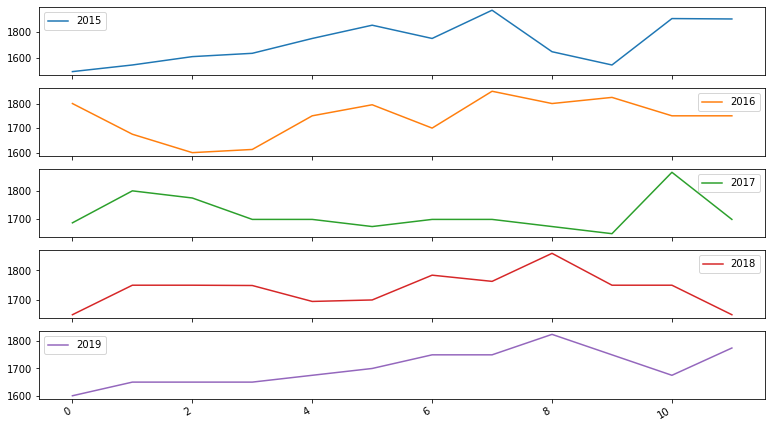

In [140]:
#median rent for studios in Astoria separated by the years

year_groups_a = agw_studios['2015':'2019'][['Astoria']].groupby(pd.Grouper(freq ='A'))
studios_annual_a = pd.DataFrame()

for yr, group in year_groups_a:
    studios_annual_a[yr.year] = group.values.ravel()
    
# Plot the yearly groups as subplots
studios_annual_a.plot(figsize = (13,8), subplots=True, legend=True);

# Plot overlapping yearly groups 
#studios_annual.plot(figsize = (15,5), subplots=False, legend=True);

### Rolling Statistics

In [9]:
#get the rolling mean and rolling std to test for stationarity 

roll_mean_a = agw_studios[['Astoria']].rolling(window=8, center=False).mean()
roll_std_a = agw_studios[['Astoria']].rolling(window=8, center=False).std()

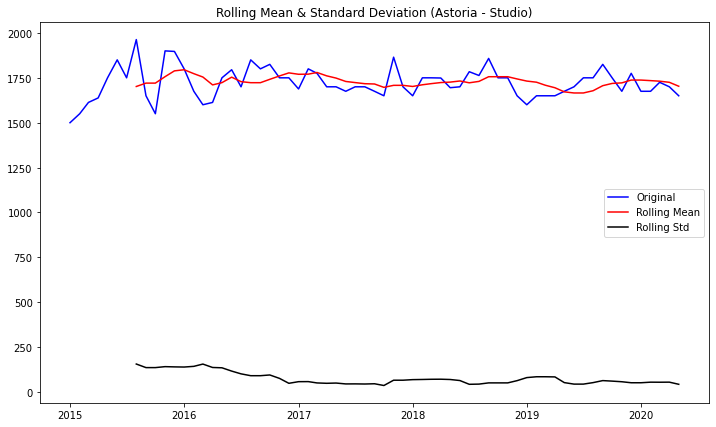

In [143]:
#plotting rolling statistics for a visual check

fig = plt.figure(figsize=(12,7))
plt.plot(agw_studios[['Astoria']], color='blue', label='Original')
plt.plot(roll_mean_a, color='red', label='Rolling Mean')
plt.plot(roll_std_a, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation (Astoria - Studio)')
plt.show(block=False)

In [11]:
#dickeyfuller test for Astoria Studios

dftest_a = adfuller(agw_studios[['Astoria']])

# Extract and display test results in a user friendly manner
dfoutput_a = pd.Series(dftest_a[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest_a[4].items():
    dfoutput_a['Critical Value (%s)'%key] = value


print ('Results of Dickey-Fuller test: \n')

print(dfoutput_a)

Results of Dickey-Fuller test: 

Test Statistic                -5.932292e+00
p-value                        2.365005e-07
#Lags Used                     0.000000e+00
Number of Observations Used    6.400000e+01
Critical Value (1%)           -3.536928e+00
Critical Value (5%)           -2.907887e+00
Critical Value (10%)          -2.591493e+00
dtype: float64


In [ ]:
# p-value is < 0.05 meaning we can reject the hypothesis that the data is not stationary

### ACF & PACF

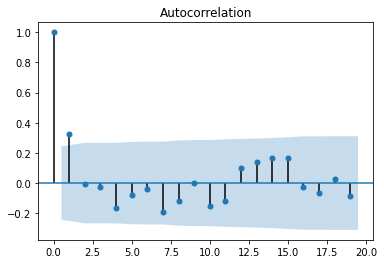

In [12]:
#plotting the auto-correlation function

plot_acf(agw_studios['Astoria'])

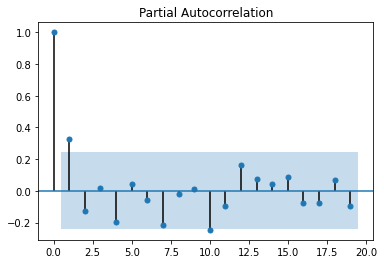

In [13]:
#plotting the partial auto-correlation function


plot_pacf(agw_studios['Astoria'])

## BASELINE MODEL

In [61]:
#Base model

astoria_studios = agw_studios[['Astoria']]

In [62]:
# Create lagged dataset
values = pd.DataFrame(astoria_studios.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
print(dataframe.head(5))

    t-1   t+1
0   NaN  1500
1  1500  1550
2  1550  1613
3  1613  1638
4  1638  1750


In [63]:
# split into train and test sets
X_base = dataframe.values
train_size = int(len(X_base) * 0.75)
train, test = X_base[1:train_size], X_base[train_size:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

In [64]:
# persistence model
def model_persistence(x):
    return x

In [65]:
# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test RMSE: %.3f' % sqrt(test_score))

Test RMSE: 54.906


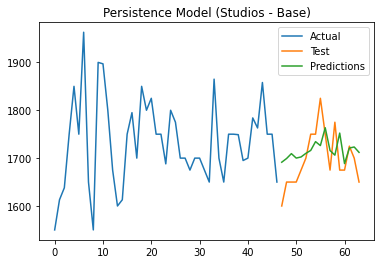

In [152]:
# plot predictions and expected results
plt.plot(train_y)
plt.plot([None for i in train_y] + [x for x in test_y])
plt.plot([None for i in train_y] + [x for x in predictions])
plt.title('Persistence Model (Studios - Base)')
plt.legend(labels = ('Actual', 'Test', 'Predictions'))
plt.show()

In [ ]:
#baseline model RMSE is 54.9, this is what we'll use as our base score to check if the other models improve or not

## ARIMA MODEL

predicted=1691.453259, expected=1600.000000
predicted=1699.166284, expected=1650.000000
predicted=1709.364194, expected=1650.000000
predicted=1700.082407, expected=1650.000000
predicted=1702.427382, expected=1675.000000
predicted=1709.996584, expected=1700.000000
predicted=1716.109492, expected=1750.000000
predicted=1734.430600, expected=1750.000000
predicted=1726.222193, expected=1825.000000
predicted=1763.485655, expected=1750.000000
predicted=1715.853710, expected=1675.000000
predicted=1706.204342, expected=1775.000000
predicted=1752.302406, expected=1675.000000
predicted=1688.530013, expected=1675.000000
predicted=1721.009621, expected=1725.000000
predicted=1723.288035, expected=1700.000000
predicted=1712.031684, expected=1650.000000
Test RMSE: 51.997


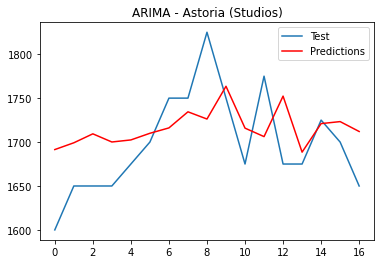

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   64
Model:                     ARMA(1, 1)   Log Likelihood                -372.118
Method:                       css-mle   S.D. of innovations             80.947
Date:                Sun, 28 Jun 2020   AIC                            752.236
Time:                        15:33:09   BIC                            760.872
Sample:                             0   HQIC                           755.638
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1721.2540     13.586    126.694      0.000    1694.626    1747.882
ar.L1.y       -0.1480      0.367     -0.403      0.687      -0.867       0.571
ma.L1.y        0.5451      0.322      1.693      0.0

In [153]:
#ARIMA model

X_rima = agw_studios[['Astoria']].values
size = int(len(X_rima) * 0.75)
train, test = X_rima[0:size], X_rima[size:len(X_rima)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(1,0,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test RMSE: %.3f' % sqrt(error))
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.title('ARIMA - Astoria (Studios)')
plt.legend(labels = ('Test', 'Predictions'))
plt.show()
print(model_fit.summary())

In [ ]:
#ARIMA model has an RMSE of 51.9 which is an improvement from base

## FB PROPHET

In [36]:
#set up for FB prophet model

fb_toria = astoria_studios

In [37]:
fb_toria.reset_index(inplace=True)
fb_toria.index.rename('', inplace=True)
fb_toria.rename(columns={'index': 'ds', 'Astoria': 'y'}, inplace=True)

/Users/judebuenaseda/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [38]:
fb_toria.head()

areaName,ds,y
,,
0,2015-01-01,1500
1,2015-02-01,1550
2,2015-03-01,1613
3,2015-04-01,1638
4,2015-05-01,1750


In [92]:
# Train/Split

X_a_studios = fb_toria['ds'].values
y_a_studios = fb_toria['y'].values

X_train = X_a_studios[:int(X_a_studios.shape[0]*0.75)]
X_test = X_a_studios[int(X_a_studios.shape[0]*0.75):]
y_train = y_a_studios[:int(X_a_studios.shape[0]*0.75)]
y_test = y_a_studios[int(X_a_studios.shape[0]*0.75):]

ast_studio_train = pd.DataFrame(y_train,index = X_train, columns = ['y'])
ast_studio_test = pd.DataFrame(y_test, index = X_test, columns = ['y'])
ast_studio_train.head()
ast_studio_train.reset_index(inplace = True)
ast_studio_train.rename(columns = {'index':'ds'}, inplace=True)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE in $$:  85.64278297347646


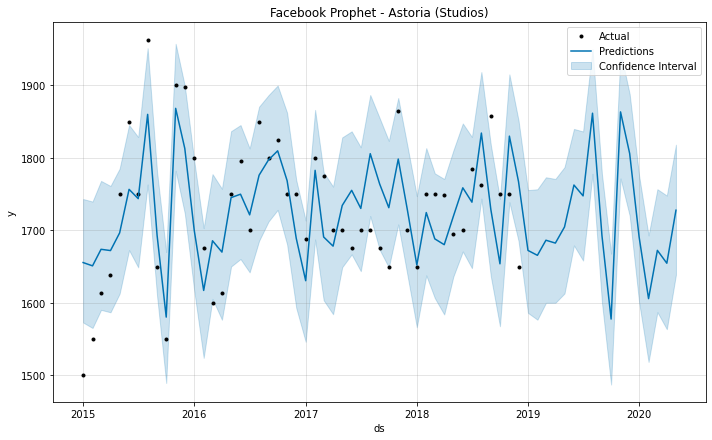

In [156]:
#fitting the prophet model along with plotting and forecasting

ast_studios_prophet = Prophet().fit(ast_studio_train)

future_ast_studios = ast_studios_prophet.make_future_dataframe(periods=17,freq = 'MS')
forecast_ast_studios = ast_studios_prophet.predict(future_ast_studios)
forecast_ast_studios.tail()

fig1_ast_studios = ast_studios_prophet.plot(forecast_ast_studios)
plt.title('Facebook Prophet - Astoria (Studios)')
plt.legend(labels = ('Actual', 'Predictions', 'Confidence Interval'))

preds_ast_studios = forecast_ast_studios[48:][['ds','yhat']].set_index('ds')
preds_ast_studios.head()

preds_ast_studios_df = pd.concat([ast_studio_test ,preds_ast_studios],axis = 1)
preds_ast_studios_df.head()

error = np.sqrt(sum((preds_ast_studios_df['y'] - preds_ast_studios_df['yhat'])**2)/len(preds_ast_studios_df))
print('RMSE in $$: ', error)

In [141]:
#FB prophet RMSE is 85.64 which is not an improvement from the previous models

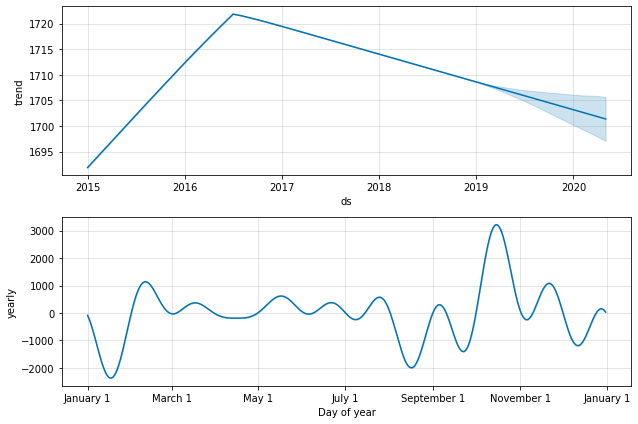

In [42]:
#plotting the trend and seasonality of the model

fig2_ast_studios = ast_studios_prophet.plot_components(forecast_ast_studios)

### One Bedroom Aparments

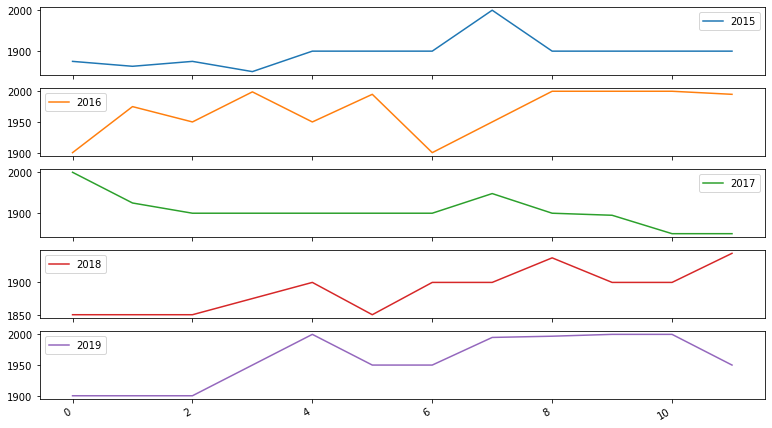

In [43]:
#set up for one bedroom apartments in Astotira

year_groups_a_1br = agw_1br['2015':'2019'][['Astoria']].groupby(pd.Grouper(freq ='A'))

# Create a new DataFrame and store yearly values in columns 
studios_annual_a_1br = pd.DataFrame()

for yr, group in year_groups_a_1br:
    studios_annual_a_1br[yr.year] = group.values.ravel()
    
# Plot the yearly groups as subplots
studios_annual_a_1br.plot(figsize = (13,8), subplots=True, legend=True);

# Plot overlapping yearly groups 
#studios_annual.plot(figsize = (15,5), subplots=False, legend=True);

### Rolling Statistics

In [44]:
#rolling mean and std for visual check 

roll_mean_a_1br = agw_1br[['Astoria']].rolling(window=8, center=False).mean()
roll_std_a_1br = agw_1br[['Astoria']].rolling(window=8, center=False).std()

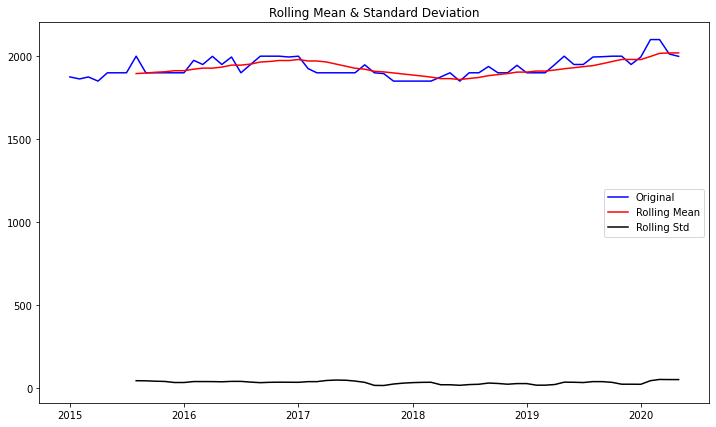

In [45]:
fig_roll_1br = plt.figure(figsize=(12,7))
plt.plot(agw_1br[['Astoria']], color='blue', label='Original')
plt.plot(roll_mean_a_1br, color='red', label='Rolling Mean')
plt.plot(roll_std_a_1br, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [46]:
#dickeyfuller test for Astoria 1BR

dftest_a_1br = adfuller(agw_1br[['Astoria']])

# Extract and display test results in a user friendly manner
dfoutput_a_1br = pd.Series(dftest_a_1br[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest_a_1br[4].items():
    dfoutput_a_1br['Critical Value (%s)'%key] = value


print ('Results of Dickey-Fuller test: \n')

print(dfoutput_a_1br)

Results of Dickey-Fuller test: 

Test Statistic                 -2.961829
p-value                         0.038616
#Lags Used                      0.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


In [ ]:
#data is stationary

### ACF & PACF

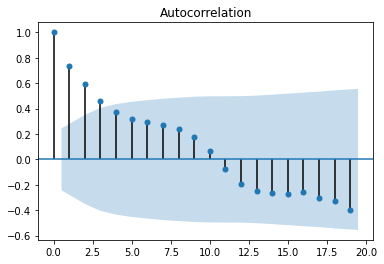

In [47]:
#auto correlation function

plot_acf(agw_1br['Astoria']);

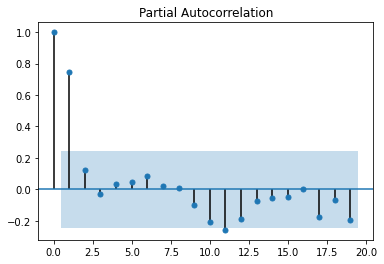

In [48]:
#partial auto correlation function

plot_pacf(agw_1br['Astoria']);

### BASELINE MODEL

In [57]:
astoria_1br = agw_1br[['Astoria']]

In [58]:
# Create lagged dataset
values_1br = pd.DataFrame(astoria_1br.values)
dataframe_1br = pd.concat([values_1br.shift(1), values_1br], axis=1)
dataframe_1br.columns = ['t-1', 't+1']
print(dataframe_1br.head(5))

    t-1   t+1
0   NaN  1875
1  1875  1863
2  1863  1875
3  1875  1850
4  1850  1900


In [59]:
# split into train and test sets
X_1br = dataframe_1br.values
train_size_1br = int(len(X_1br) * 0.75)
train_1br, test_1br = X_1br[1:train_size_1br], X_1br[train_size_1br:]
train_X_1br, train_y_1br = train_1br[:,0], train_1br[:,1]
test_X_1br, test_y_1br = test_1br[:,0], test_1br[:,1]

In [67]:
#model persistence defined above in studios

# walk-forward validation
predictions_1br = list()
for x in test_X_1br:
    yhat_1br = model_persistence(x)
    predictions_1br.append(yhat_1br)
test_score = mean_squared_error(test_y_1br, predictions_1br)
print('Test RMSE: %.3f' % sqrt(test_score))

Test RMSE: 45.295


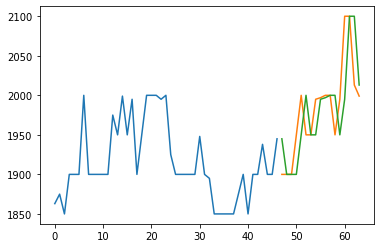

In [68]:
# plot predictions and expected results
plt.plot(train_y_1br)
plt.plot([None for i in train_y_1br] + [x for x in test_y_1br])
plt.plot([None for i in train_y_1br] + [x for x in predictions_1br])
plt.show()

In [ ]:
#base score is 45.29

### ARIMA MODEL

predicted=1927.816404, expected=1900.000000
predicted=1927.816404, expected=1900.000000
predicted=1927.816404, expected=1900.000000
predicted=1927.816404, expected=1950.000000
predicted=1927.816404, expected=2000.000000
predicted=1927.816404, expected=1950.000000
predicted=1927.816404, expected=1950.000000
predicted=1927.816404, expected=1995.000000
predicted=1927.816404, expected=1997.000000
predicted=1927.816404, expected=2000.000000
predicted=1927.816404, expected=2000.000000
predicted=1927.816404, expected=1950.000000
predicted=1927.816404, expected=1995.000000
predicted=1927.816404, expected=2100.000000
predicted=1927.816404, expected=2100.000000
predicted=1927.816404, expected=2013.000000
predicted=1927.816404, expected=1999.000000
Test RMSE: 78.722


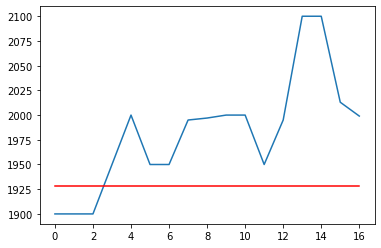

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   47
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -235.374
Method:                       css-mle   S.D. of innovations             36.125
Date:                Fri, 26 Jun 2020   AIC                            478.748
Time:                        16:59:37   BIC                            486.149
Sample:                             1   HQIC                           481.533
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2908      3.692      0.350      0.727      -5.945       8.526
ar.L1.D.y     -0.3912      0.360     -1.085      0.278      -1.098       0.315
ma.L1.D.y     -0.0322      0.403     -0.080      0.9

In [82]:
#ARIMA model

X_rima_1br = agw_1br[['Astoria']].values
size_1br = int(len(X_rima_1br) * 0.75)
train_rima_1br, test_rima_1br = X_rima_1br[0:size], X_rima_1br[size:len(X_rima_1br)]
history_rima_1br = [x for x in train_rima_1br]
predictions_rima_1br = list()
for t in range(len(test_rima_1br)):
    model_1br = ARIMA(history_rima_1br, order=(1,1,1))
    model_fit_1br = model_1br.fit(disp=0)
    output = model_fit_1br.forecast()
    yhat = output[0]
    predictions_rima_1br.append(yhat)
    obs = test_rima_1br[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error_1br = mean_squared_error(test_rima_1br, predictions_rima_1br)
print('Test RMSE: %.3f' % sqrt(error_1br))
# plot
plt.plot(test_rima_1br)
plt.plot(predictions_rima_1br, color='red')
plt.show()
print(model_fit_1br.summary())

In [ ]:
#ARIMA score of 78 which is not better than base

## FB PROPHET

In [83]:
fb_toria_1br = astoria_1br

In [84]:
fb_toria_1br.reset_index(inplace=True)
fb_toria_1br.index.rename('', inplace=True)
fb_toria_1br.rename(columns={'index': 'ds', 'Astoria': 'y'}, inplace=True)

/Users/judebuenaseda/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [86]:
fb_toria_1br.head(1)

areaName,ds,y
,,
0,2015-01-01,1875


In [94]:
# Train/Split

X_a_1br = fb_toria_1br['ds'].values
y_a_1br = fb_toria_1br['y'].values

X_train_1br = X_a_1br[:int(X_a_1br.shape[0]*0.75)]
X_test_1br = X_a_1br[int(X_a_1br.shape[0]*0.75):]
y_train_1br = y_a_1br[:int(X_a_1br.shape[0]*0.75)]
y_test_1br = y_a_1br[int(X_a_1br.shape[0]*0.75):]

ast_1br_train = pd.DataFrame(y_train_1br,index = X_train_1br, columns = ['y'])
ast_1br_test = pd.DataFrame(y_test_1br, index = X_test_1br, columns = ['y'])
ast_1br_train.head()
ast_1br_train.reset_index(inplace = True)
ast_1br_train.rename(columns = {'index':'ds'}, inplace=True)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE in $$:  44.30951987150469


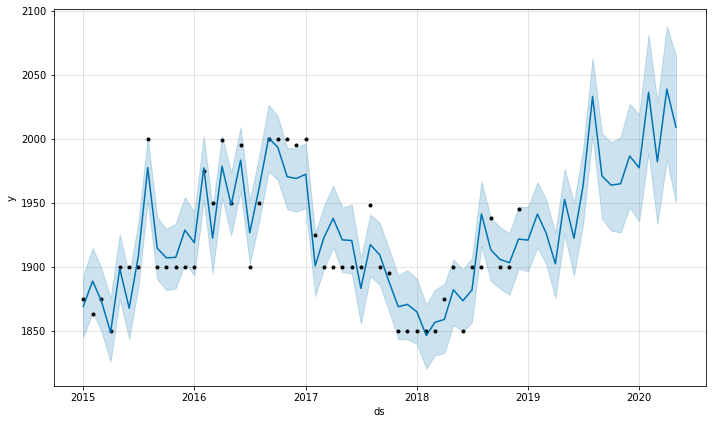

In [95]:
ast_1br_prophet = Prophet().fit(ast_1br_train)

future_ast_1br = ast_1br_prophet.make_future_dataframe(periods=17,freq = 'MS')
forecast_ast_1br = ast_1br_prophet.predict(future_ast_1br)
forecast_ast_1br.tail()

fig1_ast_1br = ast_1br_prophet.plot(forecast_ast_1br)

preds_ast_1br = forecast_ast_1br[48:][['ds','yhat']].set_index('ds')
preds_ast_1br.head()

preds_ast_1br_df = pd.concat([ast_1br_test ,preds_ast_1br],axis = 1)
preds_ast_1br_df.head()

error_prophet_1br = np.sqrt(sum((preds_ast_1br_df['y'] - preds_ast_1br_df['yhat'])**2)/len(preds_ast_1br_df))
print('RMSE in $$: ', error_prophet_1br)


In [ ]:
#FB prophet of 44 is better than previous models

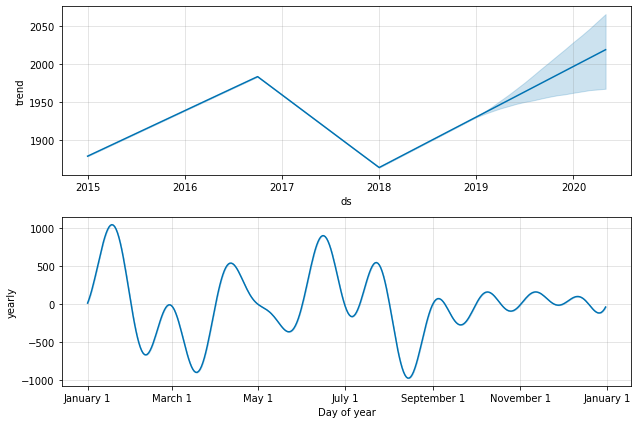

In [96]:
fig2_ast_1br = ast_1br_prophet.plot_components(forecast_ast_1br)

###  Three Bedroom Aparments + 

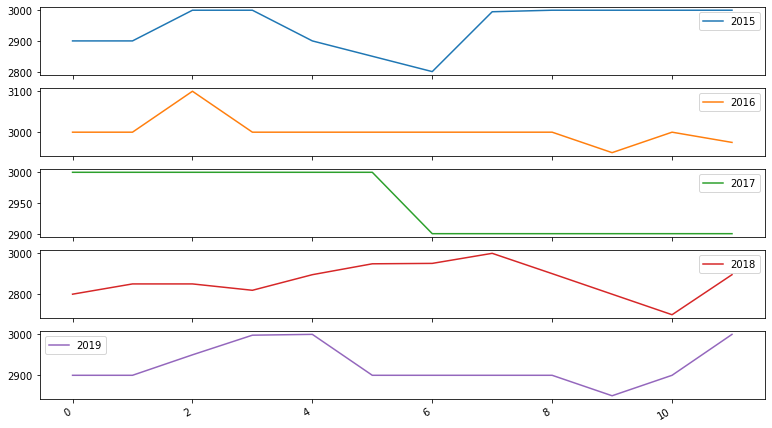

In [101]:
# Use pandas grouper to group values using annual frequency
year_groups_a_3br = agw_3br['2015':'2019'][['Astoria']].groupby(pd.Grouper(freq ='A'))

# Create a new DataFrame and store yearly values in columns 
annual_a_3br = pd.DataFrame()

for yr, group in year_groups_a_3br:
    annual_a_3br[yr.year] = group.values.ravel()
    
# Plot the yearly groups as subplots
annual_a_3br.plot(figsize = (13,8), subplots=True, legend=True);

# Plot overlapping yearly groups 
#annual_a_3br.plot(figsize = (15,5), subplots=False, legend=True);

### Rolling Statistics

In [102]:
roll_mean_a_3br = agw_3br[['Astoria']].rolling(window=8, center=False).mean()
roll_std_a_3br = agw_3br[['Astoria']].rolling(window=8, center=False).std()

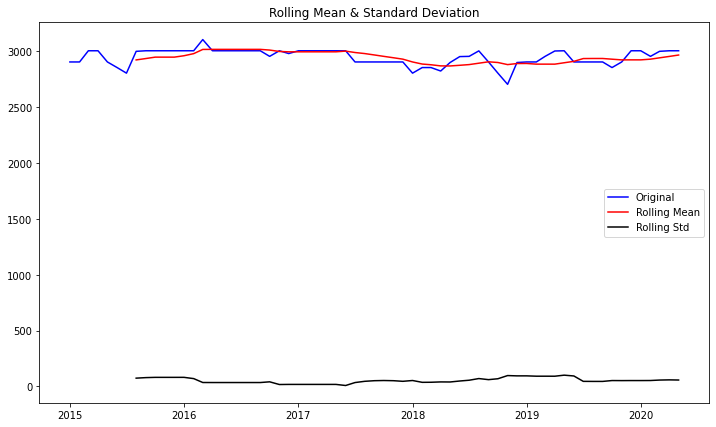

In [103]:
fig_roll_3br = plt.figure(figsize=(12,7))
plt.plot(agw_3br[['Astoria']], color='blue', label='Original')
plt.plot(roll_mean_a_3br, color='red', label='Rolling Mean')
plt.plot(roll_std_a_3br, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [105]:
#dickeyfuller test for Astoria Studios

dftest_a_3br = adfuller(agw_3br[['Astoria']])

# Extract and display test results in a user friendly manner
dfoutput_a_3br = pd.Series(dftest_a_3br[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest_a_3br[4].items():
    dfoutput_a_3br['Critical Value (%s)'%key] = value


print ('Results of Dickey-Fuller test: \n')

print(dfoutput_a_3br)

Results of Dickey-Fuller test: 

Test Statistic                 -3.579263
p-value                         0.006170
#Lags Used                      0.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


In [ ]:
#data is stationary

### ACF & PACF

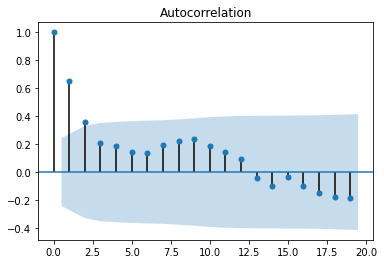

In [106]:
plot_acf(agw_3br['Astoria']);

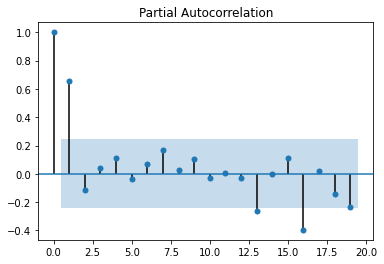

In [107]:
plot_pacf(agw_3br['Astoria']);

### BASELINE MODEL

In [108]:
astoria_3br = agw_3br[['Astoria']]

In [109]:
# Create lagged dataset
values_3br = pd.DataFrame(astoria_3br.values)
dataframe_3br = pd.concat([values_3br.shift(1), values_3br], axis=1)
dataframe_3br.columns = ['t-1', 't+1']
print(dataframe_3br.head(5))

    t-1   t+1
0   NaN  2900
1  2900  2900
2  2900  3000
3  3000  3000
4  3000  2900


In [110]:
# split into train and test sets
X_3br = dataframe_3br.values
train_size_3br = int(len(X_3br) * 0.75)
train_3br, test_3br = X_3br[1:train_size_3br], X_3br[train_size_3br:]
train_X_3br, train_y_3br = train_3br[:,0], train_3br[:,1]
test_X_3br, test_y_3br = test_3br[:,0], test_3br[:,1]

In [111]:
#model persistence defined above in studios

# walk-forward validation
predictions_3br = list()
for x in test_X_3br:
    yhat_3br = model_persistence(x)
    predictions_3br.append(yhat_3br)
test_score_3br = mean_squared_error(test_y_3br, predictions_3br)
print('Test RMSE: %.3f' % sqrt(test_score_3br))

Test RMSE: 44.973


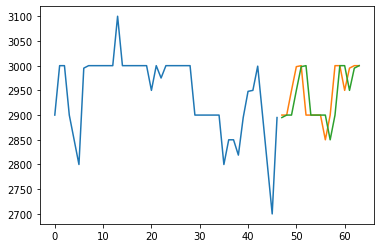

In [112]:
# plot predictions and expected results
plt.plot(train_y_3br)
plt.plot([None for i in train_y_3br] + [x for x in test_y_3br])
plt.plot([None for i in train_y_3br] + [x for x in predictions_3br])
plt.show()

In [ ]:
#base model score is 44.97

### ARIMA MODEL

predicted=2929.191492, expected=2900.000000
predicted=2929.191492, expected=2900.000000
predicted=2929.191492, expected=2950.000000
predicted=2929.191492, expected=2998.000000
predicted=2929.191492, expected=3000.000000
predicted=2929.191492, expected=2900.000000
predicted=2929.191492, expected=2900.000000
predicted=2929.191492, expected=2900.000000
predicted=2929.191492, expected=2900.000000
predicted=2929.191492, expected=2850.000000
predicted=2929.191492, expected=2900.000000
predicted=2929.191492, expected=3000.000000
predicted=2929.191492, expected=3000.000000
predicted=2929.191492, expected=2950.000000
predicted=2929.191492, expected=2995.000000
predicted=2929.191492, expected=3000.000000
predicted=2929.191492, expected=3000.000000
Test RMSE: 52.713


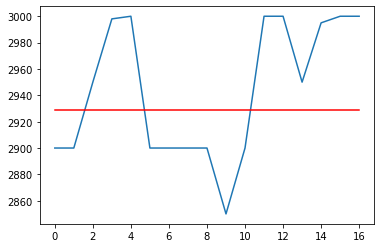

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   48
Model:                     ARMA(1, 1)   Log Likelihood                -262.924
Method:                       css-mle   S.D. of innovations             57.554
Date:                Fri, 26 Jun 2020   AIC                            533.848
Time:                        18:01:21   BIC                            541.333
Sample:                             0   HQIC                           536.676
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2939.5092     21.609    136.031      0.000    2897.156    2981.862
ar.L1.y        0.5739      0.180      3.181      0.001       0.220       0.928
ma.L1.y        0.1353      0.224      0.605      0.5

In [114]:
#ARIMA model

X_rima_3br = agw_3br[['Astoria']].values
size_3br = int(len(X_rima_3br) * 0.75)
train_rima_3br, test_rima_3br = X_rima_3br[0:size], X_rima_3br[size:len(X_rima_3br)]
history_rima_3br = [x for x in train_rima_3br]
predictions_rima_3br = list()
for t in range(len(test_rima_3br)):
    model_3br = ARIMA(history_rima_3br, order=(1,0,1))
    model_fit_3br = model_3br.fit(disp=0)
    output = model_fit_3br.forecast()
    yhat = output[0]
    predictions_rima_3br.append(yhat)
    obs = test_rima_3br[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error_3br = mean_squared_error(test_rima_3br, predictions_rima_3br)
print('Test RMSE: %.3f' % sqrt(error_3br))
# plot
plt.plot(test_rima_3br)
plt.plot(predictions_rima_3br, color='red')
plt.show()
print(model_fit_3br.summary())

In [ ]:
#ARIMA score is 52.71 , not better than base

## FB PROPHET

In [115]:
fb_toria_3br = astoria_3br

In [116]:
fb_toria_3br.reset_index(inplace=True)
fb_toria_3br.index.rename('', inplace=True)
fb_toria_3br.rename(columns={'index': 'ds', 'Astoria': 'y'}, inplace=True)

/Users/judebuenaseda/.pyenv/versions/3.8.2/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [117]:
fb_toria_3br.head(1)

areaName,ds,y
,,
0,2015-01-01,2900


In [118]:
# Train/Split

X_a_3br = fb_toria_3br['ds'].values
y_a_3br = fb_toria_3br['y'].values

X_train_3br = X_a_3br[:int(X_a_3br.shape[0]*0.75)]
X_test_3br = X_a_3br[int(X_a_3br.shape[0]*0.75):]
y_train_3br = y_a_3br[:int(X_a_3br.shape[0]*0.75)]
y_test_3br = y_a_3br[int(X_a_3br.shape[0]*0.75):]

ast_3br_train = pd.DataFrame(y_train_3br,index = X_train_3br, columns = ['y'])
ast_3br_test = pd.DataFrame(y_test_3br, index = X_test_3br, columns = ['y'])
ast_3br_train.head()
ast_3br_train.reset_index(inplace = True)
ast_3br_train.rename(columns = {'index':'ds'}, inplace=True)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE in $$:  172.16958428427992


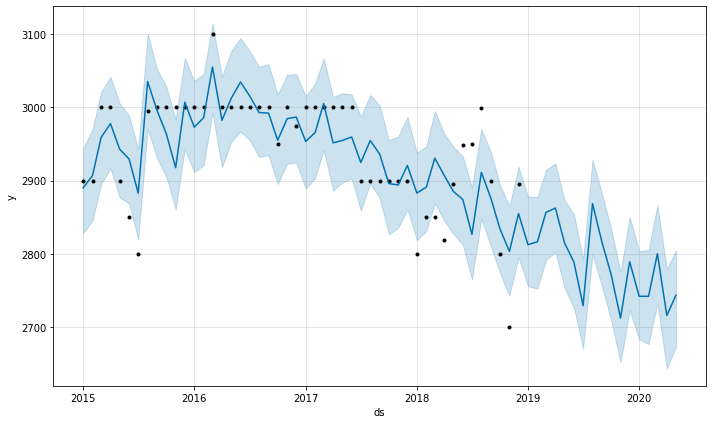

In [120]:
ast_3br_prophet = Prophet().fit(ast_3br_train)

future_ast_3br = ast_3br_prophet.make_future_dataframe(periods=17,freq = 'MS')
forecast_ast_3br = ast_3br_prophet.predict(future_ast_3br)
forecast_ast_3br.tail()

fig1_ast_3br = ast_3br_prophet.plot(forecast_ast_3br)

preds_ast_3br = forecast_ast_3br[48:][['ds','yhat']].set_index('ds')
preds_ast_3br.head()

preds_ast_3br_df = pd.concat([ast_3br_test ,preds_ast_3br],axis = 1)
preds_ast_3br_df.head()

error_prophet_3br = np.sqrt(sum((preds_ast_3br_df['y'] - preds_ast_3br_df['yhat'])**2)/len(preds_ast_3br_df))
print('RMSE in $$: ', error_prophet_3br)


In [ ]:
#FB prophet score is 172 which is way off from base and ARIMA

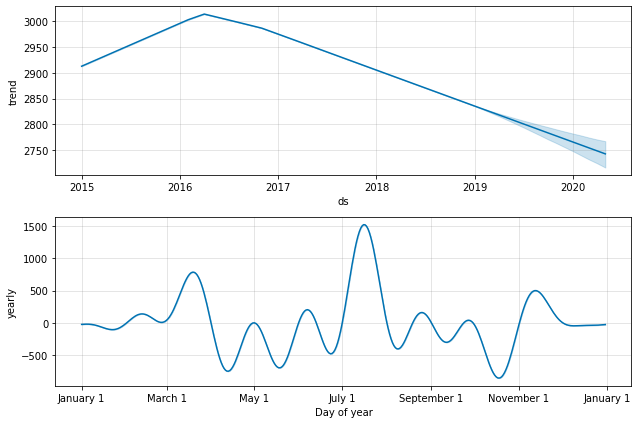

In [121]:
fig3_ast_3br = ast_3br_prophet.plot_components(forecast_ast_3br)